In [ ]:
import sys
sys.path.extend(['/users/students/r0749898/thesis/'])

In [1]:
from datasets.SHHS_dataset_timeonly import SHHS_dataset_1, EEGdataModule

from models.simclr_model import SimCLR
from models.supervised_model import SupervisedModel
import torch
import matplotlib.pyplot as plt
import numpy as np
from argparse import Namespace
from copy import deepcopy
from utils.helper_functions import load_model, SimCLRdataModule
from trainers.train_supervised import train_supervised


## Define dataset: 10 patients for training, 5 for validation and 30 for testing


In [2]:
data_args = {
  # "DATA_PATH": "/esat/biomeddata/SHHS_Dataset/no_backup/",
  "DATA_PATH": "../../thesis01/data/",
  "data_split": [4, 1],
  "first_patient": 15,
  "num_patients_train": 1,
  "num_patients_test": 1,
  "batch_size": 64,
  "num_workers": 12
}

dm = EEGdataModule(**data_args)  # Load datamodule
dm.setup()

In [3]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print(device)

cpu


## Run data through the pretrained SimCLR encoder to get the representations
- The SimCLR model was pretrained on 100 patients (+50 for validation)

In [4]:
encoder_path = "../trained_models/cnn_simclr_500pat.ckpt"
pretrained_model = load_model(SimCLR, encoder_path)  # Load pretrained simclr model
simclr_dm = SimCLRdataModule(pretrained_model, dm, data_args['batch_size'], data_args['num_workers'], device)

C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
  rank_zero_warn(
C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.
  rank_zero_warn(


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

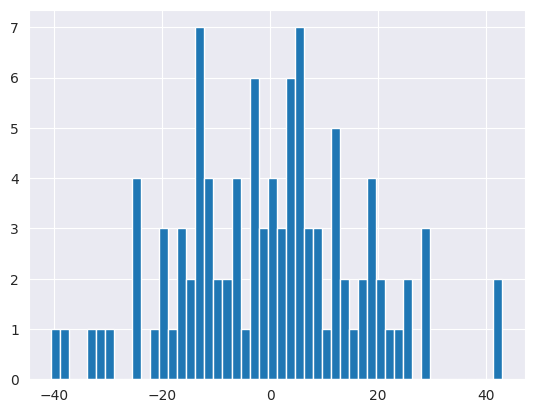

In [34]:
## Analyse the features: histogram and t-SNE plot
feature = next(iter(simclr_dm.train_dataloader()))[0][0]
plt.hist(np.asarray(feature), bins=50)
plt.show()

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
tsne = TSNE(n_components=2, n_iter=300, verbose=1, perplexity=125)
x, y = simclr_dm.train_ds.tensors
tsne_results = tsne.fit_transform(x)

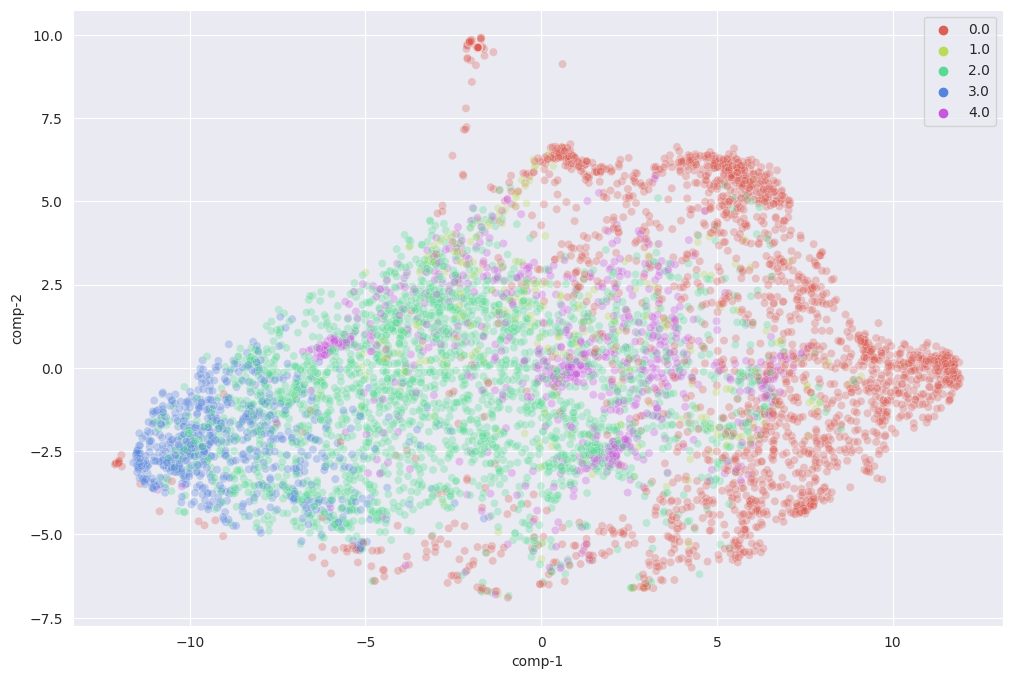

In [53]:
# Plot results
df = pd.DataFrame()
df['comp-1'] = tsne_results[:,0]
df['comp-2'] = tsne_results[:,1]
df["y"] = y
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="comp-1", y="comp-2",
    hue=df.y.tolist(),
    palette=sns.color_palette("hls", 5),
    data=df,
    legend="full",
    alpha=0.3
)
plt.savefig('tsne_plot.png', facecolor="white")


In [44]:
torch.cat([x[0] for x in iter(dm.train_dataloader())],0).squeeze()

tensor([[-2.5585, -2.9150, -3.5834,  ..., -0.0735, -0.2488,  0.3356],
        [ 0.0856, -0.4145, -0.5102,  ..., -0.2307,  0.0464, -0.1253],
        [-0.1522, -0.5600, -0.7612,  ..., -1.2676, -1.0391, -0.8124],
        ...,
        [ 0.3048, -0.8664, -0.5290,  ...,  3.0974,  2.8806,  2.1380],
        [ 1.4177,  0.4474,  0.3227,  ...,  0.0473, -0.0472, -0.0187],
        [ 0.5987,  0.6748,  0.1235,  ...,  1.3042,  0.9081,  0.1798]])

In [49]:
dm.eeg_train

## Train a logistic classifier on top


In [5]:
logistic_args = {
  "MODEL_TYPE": "SupervisedModel",
  "save_name": "logistic_on_simclr",
  "DATA_PATH": data_args['DATA_PATH'],
  "CHECKPOINT_PATH": "checkpoints",

  "encoder": "None",
  "encoder_hparams": {},

  "classifier": "logistic",
  "classifier_hparams":{
      "input_dim": 100
  },
  "data_hparams": data_args,

  "trainer_hparams":{
    "max_epochs": 1
  },
  "optim_hparams": {
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "lr_hparams": {
        "gamma": 0.1,
        "milestones": [10]
    }
  }
}
logistic_model, logistic_res = train_supervised(Namespace(**logistic_args), device=device, dm=simclr_dm)
print(logistic_res)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'classifier' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['classifier'])`.
  rank_zero_warn(

  | Name        | Type             | Params
-------------------------------------------------
0 | encoder     | Identity         | 0     
1 | classifier  | Linear           | 505   
2 | net         | Sequential       | 505   
3 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
505       Trainable params
0         Non-trainable params
505       Total params
0.002     Total estimated model params size (MB)
C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\loggers\tensor

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:1892: PossibleUserWarning: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:489: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\loggers\tensorboard.py:250: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

{'test_acc': 0.47649770975112915, 'test_kappa': 0.18703929718304532, 'val': 0.6546391844749451}


## Train a supervised model with the same dataset for comparison


In [8]:
supervised_args = {
  "MODEL_TYPE": "SupervisedModel",
  "save_name": "supervised_simclr",
  "DATA_PATH": data_args['DATA_PATH'],
  "CHECKPOINT_PATH": "checkpoints",

  "encoder": "CNN_head",
  "encoder_hparams": {
    "conv_filters": [32, 64, 64],
    "representation_dim": 100
  },

  "classifier": "logistic",
  "classifier_hparams":{
      "input_dim": 100
  },
  "data_hparams": data_args,

  "trainer_hparams":{
    "max_epochs": 25
  },
  "optim_hparams": {
    "lr": 1e-5,
    "weight_decay": 1e-3,
    "lr_hparams": {
      "gamma": 0.1,
      "milestones": [10]
    }
  }
}
sup_model, sup_res = train_supervised(Namespace(**supervised_args), device, dm=dm)
print(sup_res)

Global seed set to 42


Couldn't find file at path:  /esat/biomeddata/SHHS_Dataset/no_backup/n0068_eeg.mat
Couldn't find file at path:  /esat/biomeddata/SHHS_Dataset/no_backup/n0086_eeg.mat
Couldn't find file at path:  /esat/biomeddata/SHHS_Dataset/no_backup/n0094_eeg.mat


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/users/students/r0749898/miniconda3/envs/newthesisenv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
  rank_zero_warn(
/users/students/r0749898/miniconda3/envs/newthesisenv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'classifier' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['classifier'])`.
  rank_zero_warn(
Missing logger folder: checkpoints/supervised_simclr/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name        | Type             | Params
---------

Sanity Checking: 0it [00:00, ?it/s]

/users/students/r0749898/miniconda3/envs/newthesisenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
/users/students/r0749898/miniconda3/envs/newthesisenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: 0it [00:00, ?it/s]

{'test': 0.7070562243461609, 'val': 0.7349950671195984}


## Finetuned supervised model

In [12]:
finetune_logistic_args = {
  "MODEL_TYPE": "SupervisedModel",
  "save_name": "finetuned_simclr",
  "DATA_PATH": data_args['DATA_PATH'],
  "CHECKPOINT_PATH": "checkpoints",

  "encoder": "CNN_head",
  "encoder_hparams": {
    "conv_filters": [32, 64, 64],
    "representation_dim": 100
  },

  "classifier": "logistic",
  "classifier_hparams":{
      "input_dim": 100
  },
  "data_hparams": data_args,

  "trainer_hparams":{
    "max_epochs": 50
  },
  "optim_hparams": {
    "lr": 2e-6,
    "weight_decay": 0,
    "lr_hparams": None
  }
}
pretrained_encoder = type(pretrained_model.f)(**finetune_logistic_args['encoder_hparams'])
pretrained_classifier = type(logistic_model.classifier)(finetune_logistic_args['classifier_hparams']['input_dim'], 5)
pretrained_classifier.load_state_dict(logistic_model.classifier.state_dict())
pretrained_encoder.load_state_dict(pretrained_model.f.state_dict())
fully_tuned_model, fully_tuned_res = train_supervised(Namespace(**finetune_logistic_args), device, dm=dm, pretrained_encoder=pretrained_encoder, pretrained_classifier=pretrained_classifier)
print(fully_tuned_res)

Global seed set to 42


Couldn't find file at path:  /esat/biomeddata/SHHS_Dataset/no_backup/n0068_eeg.mat
Couldn't find file at path:  /esat/biomeddata/SHHS_Dataset/no_backup/n0086_eeg.mat
Couldn't find file at path:  /esat/biomeddata/SHHS_Dataset/no_backup/n0094_eeg.mat


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name        | Type             | Params
-------------------------------------------------
0 | encoder     | CNN_head         | 2.4 M 
1 | classifier  | Linear           | 505   
2 | net         | Sequential       | 2.4 M 
3 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.678     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
/users/students/r0749898/miniconda3/envs/newthesisenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: 0it [00:00, ?it/s]

{'test': 0.7279564738273621, 'val': 0.7571304440498352}


In [ ]:
print(fully_tuned_res)